<a href="https://colab.research.google.com/github/falawar7/AAI_635O/blob/main/Week3/FE_DL_Experimenting_With_NCF_Based_Recommendation_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install recommenders[gpu] -f https://download.pytorch.org/whl/cu111/torch_stable.html

In [ ]:
#!pip install recommenders

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
#from recommenders.datasets import movielens
from recommenders.utils.notebook_utils import is_jupyter
from recommenders.datasets.python_splitters import python_chrono_split,python_stratified_split
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k,
                                                     recall_at_k, get_top_k_items)

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

System version: 3.12.4 (tags/v3.12.4:8e8a4ba, Jun  6 2024, 19:30:16) [MSC v.1940 64 bit (AMD64)]
Pandas version: 2.2.2
Tensorflow version: 2.19.0


In [ ]:
#!pip install --upgrade tensorflow

In [ ]:
# top k items to recommend
TOP_K = 10

# Select MovieLens data size: 100k, 1m, 10m, or 20m
#MOVIELENS_DATA_SIZE = '100k'

# Model parameters
EPOCHS = 50
BATCH_SIZE = 256

SEED = 42

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

## 1. Load dataset

In [ ]:
#df = pd.read_excel('/content/drive/Othercomputers/THINKPAD-T14/AI/Reommender_System/Week2/Lesson2_From_Course/Rec_sys_data.xlsx')
df = pd.read_excel('Rec_sys_data.xlsx')

In [ ]:
df= df[['CustomerID','StockCode','Quantity','DeliveryDate']]

In [ ]:
df["StockCode"] = df["StockCode"].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()

C:\Users\Faisal\AppData\Local\Temp\ipykernel_12592\27731373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["StockCode"] = df["StockCode"].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()


In [ ]:
df = df.dropna()
print(df.shape)
df

(246706, 4)


,CustomerID,StockCode,Quantity,DeliveryDate
1,17850,71053.0,6,2010-12-02 08:26:00
2,17850,21730.0,6,2010-12-03 08:26:00
4,17850,22752.0,2,2010-12-04 08:26:00
7,17850,22633.0,6,2010-12-04 08:28:00
8,17850,22632.0,6,2010-12-03 08:28:00
...,...,...,...,...
272399,15249,23399.0,12,2011-10-08 11:37:00
272400,15249,22727.0,4,2011-10-08 11:37:00
272401,15249,23434.0,12,2011-10-08 11:37:00
272402,15249,23340.0,12,2011-10-07 11:37:00


In [ ]:
#header=["userID", "itemID", "rating", "timestamp"]

df = df.rename(columns={

    'CustomerID':"userID",'StockCode':"itemID",'Quantity':"rating",'DeliveryDate':"timestamp"

})

df["userID"] = df["userID"].astype(int)
df["itemID"] = df["itemID"].astype(int)

## 2. Split the data using the Spark chronological splitter provided in utilities

In [ ]:
train, test = python_chrono_split(df, 0.75)

In [ ]:
train_file = "./train.csv"
test_file = "./test.csv"
train.to_csv(train_file, index=False)
test.to_csv(test_file, index=False)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185041 entries, 37126 to 137323
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userID     185041 non-null  int64         
 1   itemID     185041 non-null  int64         
 2   rating     185041 non-null  int64         
 3   timestamp  185041 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 7.1 MB


## 3. Train the NCF model on the training data, and get the top-k recommendations for our testing data
NCF accepts implicit feedback and generates prospensity of items to be recommended to users in the scale of 0 to 1. A recommended item list can then be generated based on the scores. Note that this quickstart notebook is using a smaller number of epochs to reduce time for training. As a consequence, the model performance will be slighlty deteriorated.

In [ ]:
data = NCFDataset(train_file=train_file, test_file=test_file, seed=SEED)

INFO:recommenders.models.ncf.dataset:Indexing ./train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ./test.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ./test_full.csv ...


In [ ]:
model = NCF (
    n_users=data.n_users,
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

C:\Users\Faisal\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [ ]:
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time))

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [10.59s]: train_loss = 0.307290 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [9.22s]: train_loss = 0.292234 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [9.47s]: train_loss = 0.285934 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [8.61s]: train_loss = 0.280942 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [8.28s]: train_loss = 0.278336 


Took 475.0266 seconds for training.


In [ ]:
with Timer() as test_time:
    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item)
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time))

Took 12.4673 seconds for prediction.


## 4. Evaluate how well NCF performs
The ranking metrics are used for evaluation.

In [ ]:
eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.031396
NDCG:	0.073275
Precision@K:	0.049085
Recall@K:	0.056756


In [ ]:
#df_order = pd.read_excel('/content/drive/Othercomputers/THINKPAD-T14/AI/Reommender_System/Week2/Lesson2_From_Course/Rec_sys_data.xlsx', 'order')
#df_customer = pd.read_excel('/content/drive/Othercomputers/THINKPAD-T14/AI/Reommender_System/Week2/Lesson2_From_Course/Rec_sys_data.xlsx', 'customer')
#df_product = pd.read_excel('/content/drive/Othercomputers/THINKPAD-T14/AI/Reommender_System/Week2/Lesson2_From_Course/Rec_sys_data.xlsx', 'product')


In [ ]:
df_order = pd.read_excel('Rec_sys_data.xlsx', 'order')
df_customer = pd.read_excel('Rec_sys_data.xlsx', 'customer')
df_product = pd.read_excel('Rec_sys_data.xlsx', 'product')

In [ ]:
all_predictions[all_predictions['userID']==17850].nlargest(10,'prediction')

,userID,itemID,timestamp,prediction
8943704,17850,22998,NaT,0.986354
8942245,17850,21232,NaT,0.982246
8943545,17850,22834,NaT,0.979174
8943702,17850,22996,NaT,0.958606
8942293,17850,21314,NaT,0.957805
8942930,17850,22219,NaT,0.947588
8944480,17850,84879,NaT,0.926590
8942201,17850,21169,NaT,0.908606
8943413,17850,22713,NaT,0.901984
8942893,17850,22178,NaT,0.897836


In [ ]:
all_predictions = all_predictions[['userID','itemID','prediction']]

In [ ]:
all_predictions = all_predictions.rename(columns={

    "userID":'CustomerID',"itemID":'StockCode',"rating":'Quantity','prediction':'probability'

})

In [ ]:
def recommend_product(customer_id):

  print(" \n---------- Top 5 Bought StockCodes -----------\n")


  print(df_order[df_order['CustomerID']==customer_id][['CustomerID','StockCode','Quantity']].nlargest(5,'Quantity'))

  top_5_bought = df_order[df_order['CustomerID']==customer_id][['CustomerID','StockCode','Quantity']].nlargest(5,'Quantity')

  print('\n-------Product Name of bought StockCodes ------\n')

  print(df_product[df_product.StockCode.isin(top_5_bought.StockCode)]['Product Name'])


  print("\n --------- Top 5 Recommendations ------------ \n")

  print(all_predictions[all_predictions['CustomerID']==customer_id].nlargest(5,'probability'))

  recommend = all_predictions[all_predictions['CustomerID']==customer_id].nlargest(5,'probability')

  print('\n-------Product Name of Recommendations ------\n')

  print(df_product[df_product.StockCode.isin(recommend.StockCode)]['Product Name'])


## 5. Recommendation's

In [ ]:
def recommend_product(customer_id):
    print(" \n---------- Top 5 Bought StockCodes -----------\n")

    print(df_order[df_order['CustomerID'] == customer_id][['CustomerID', 'StockCode', 'Quantity']].nlargest(10, 'Quantity'))

    top_5_bought = df_order[df_order['CustomerID'] == customer_id][['CustomerID', 'StockCode', 'Quantity']].nlargest(10, 'Quantity')

    print('\n-------Product Name of bought StockCodes ------\n')
    print(df_product[df_product.StockCode.isin(top_5_bought.StockCode)]['Product Name'])

    print("\n --------- Top 5 Recommendations ------------ \n")
    print(all_predictions[all_predictions['CustomerID'] == customer_id].nlargest(10, 'probability'))

    recommend = all_predictions[all_predictions['CustomerID'] == customer_id].nlargest(10, 'probability')

    print('\n-------Product Name of Recommendations ------\n')
    print(df_product[df_product.StockCode.isin(recommend.StockCode)]['Product Name'])

    # Print evaluation metrics for the user
    print("\n---------- Evaluation Metrics -----------\n")
    print("MAP:\t%f" % eval_map_user,
          "NDCG:\t%f" % eval_ndcg_user,
          "Precision@K:\t%f" % eval_precision_user,
          "Recall@K:\t%f" % eval_recall_user, sep='\n')


In [ ]:
recommend_product(13137)

 
---------- Top 5 Bought StockCodes -----------

        CustomerID StockCode  Quantity
234414       13137     84077        48
234443       13137     23321        13
50797        13137     21985        12
234404       13137     22296        12
234418       13137     22297        12

-------Product Name of bought StockCodes ------

70      MightySkins Skin Decal Wrap Compatible with Li...
490           Window Tint Film Mitsubishi (all doors) DIY
694     Harriton Men's Paradise Short-Sleeve Performan...
1065    MightySkins Skin For Samsung Galaxy J3 (2016),...
1339    MightySkins Skin Decal Wrap Compatible with Le...
Name: Product Name, dtype: object

 --------- Top 5 Recommendations ------------ 

         CustomerID  StockCode  probability
1354297       13137      22383     0.980340
1355666       13137      84991     0.920698
1353348       13137      21094     0.912518
1353343       13137      21086     0.900611
1353653       13137      21559     0.889826

-------Product Name of Recom

In [ ]:
recommend_product(15127)


 
---------- Top 5 Bought StockCodes -----------

        CustomerID StockCode  Quantity
272296       15127     23263        48
272287       15127     23354        24
272288       15127     22813        24
272289       15127     23096        24
272285       15127     21181        12

-------Product Name of bought StockCodes ------

13                billyboards Porcelain School Chalkboard
374     MightySkins Protective Vinyl Skin Decal for Po...
923     Zoan Synchrony Duo Sport Electric Snow Helmet ...
952     MightySkins Skin Decal Wrap Compatible with Sm...
1576    EMPIRE KLIX Klutch Designer Wallet Case for LG G2
Name: Product Name, dtype: object

 --------- Top 5 Recommendations ------------ 

         CustomerID  StockCode  probability
4600086       15127      23356     0.800556
4598934       15127      22113     0.798470
4598730       15127      21818     0.795763
4598408       15127      21314     0.786580
4598794       15127      21908     0.785450

-------Product Name of Recom

In [ ]:
recommend_product(15187)

 
---------- Top 5 Bought StockCodes -----------

        CustomerID StockCode  Quantity
168005       15187     84945        72
230220       15187     22128        60
265118       15187     84945        48
127141       15187     22197        36
230218       15187     23310        36

-------Product Name of bought StockCodes ------

236     MightySkins Skin Decal Wrap Compatible with HP...
559     Extreme Networks OUTDOOR IP66 802.3AT GB ETHRT...
1817                     Women's Rialto Adora Ballet Flat
1821    Clear 18 Note Acrylic Box Musical Paperweight ...
Name: Product Name, dtype: object

 --------- Top 5 Recommendations ------------ 

         CustomerID  StockCode  probability
4702533       15187      22333     0.935347
4703203       15187      23041     0.934376
4701767       15187      21240     0.927637
4703424       15187      23286     0.918538
4701765       15187      21238     0.918083

-------Product Name of Recommendations ------

1       Eye Buy Express Prescription Gl

# **Model2 on NueMF**

In [ ]:
model2 = NCF (
    n_users=data.n_users,
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=16,
    layer_sizes=[32,16,8],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

C:\Users\Faisal\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [ ]:
with Timer() as train_time:
    model2.fit(data)

print("Took {} seconds for training.".format(train_time))

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [8.47s]: train_loss = 0.234096 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [8.81s]: train_loss = 0.208367 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [9.18s]: train_loss = 0.193167 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [8.76s]: train_loss = 0.185109 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [9.10s]: train_loss = 0.178334 


Took 468.9649 seconds for training.


In [ ]:
with Timer() as test_time:
    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item)
        users.extend(user)
        items.extend(item)
        preds.extend(list(model2.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time))

Took 12.3786 seconds for prediction.


In [ ]:
eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.044629
NDCG:	0.091884
Precision@K:	0.057776
Recall@K:	0.080322


In [ ]:
all_predictions[all_predictions['userID']==12346].nlargest(5,'prediction')

,userID,itemID,timestamp,prediction
1918,12346,23167,NaT,0.999456
1777,12346,23014,NaT,0.988943
1921,12346,23170,NaT,0.982023
1925,12346,23174,NaT,0.970437
1926,12346,23175,NaT,0.944468


In [ ]:
all_predictions = all_predictions.rename(columns={

    "userID":'CustomerID',"itemID":'StockCode',"rating":'Quantity','prediction':'probability'

})

In [ ]:
def recommend_product(customer_id):

  print(" \n---------- Top 5 Bought StockCodes -----------\n")


  print(df_order[df_order['CustomerID']==customer_id][['CustomerID','StockCode','Quantity']].nlargest(5,'Quantity'))

  top_5_bought = df_order[df_order['CustomerID']==customer_id][['CustomerID','StockCode','Quantity']].nlargest(5,'Quantity')

  print('\n-------Product Name of bought StockCodes ------\n')

  print(df_product[df_product.StockCode.isin(top_5_bought.StockCode)]['Product Name'])


  print("\n --------- Top 5 Recommendations ------------ \n")

  print(all_predictions[all_predictions['CustomerID']==customer_id].nlargest(5,'probability'))

  recommend = all_predictions[all_predictions['CustomerID']==customer_id].nlargest(5,'probability')

  print('\n-------Product Name of Recommendations ------\n')

  print(df_product[df_product.StockCode.isin(recommend.StockCode)]['Product Name'])


### 5. Recommendation's

In [ ]:
recommend_product(17850)

 
---------- Top 5 Bought StockCodes -----------

      CustomerID StockCode  Quantity
285        17850    82494L        12
2629       17850    85123A        12
2634       17850     71053        12
2978       17850     71053        12
2983       17850    85123A        12

-------Product Name of bought StockCodes ------

135    Mediven Sheer and Soft 15-20 mmHg Thigh w/ Lac...
179           AARCO Enclosed Wall Mounted Bulletin Board
967    Awkward Styles Shamrock Flag St. Patrick's Day...
Name: Product Name, dtype: object

 --------- Top 5 Recommendations ------------ 

         CustomerID  StockCode timestamp  probability
8943000       17850      22300       NaT     0.996899
8943545       17850      22834       NaT     0.994837
8941892       17850      17003       NaT     0.988720
8942655       17850      21870       NaT     0.985449
8944559       17850      85175       NaT     0.977981

-------Product Name of Recommendations ------

550     Union 3" Female Ports Stainless Steel Pipe F

In [ ]:
recommend_product(15127)


 
---------- Top 5 Bought StockCodes -----------

        CustomerID StockCode  Quantity
272296       15127     23263        48
272287       15127     23354        24
272288       15127     22813        24
272289       15127     23096        24
272285       15127     21181        12

-------Product Name of bought StockCodes ------

13                billyboards Porcelain School Chalkboard
374     MightySkins Protective Vinyl Skin Decal for Po...
923     Zoan Synchrony Duo Sport Electric Snow Helmet ...
952     MightySkins Skin Decal Wrap Compatible with Sm...
1576    EMPIRE KLIX Klutch Designer Wallet Case for LG G2
Name: Product Name, dtype: object

 --------- Top 5 Recommendations ------------ 

         CustomerID  StockCode timestamp  probability
4599505       15127      22737       NaT     0.999916
4599577       15127      22812       NaT     0.999896
4599574       15127      22809       NaT     0.999256
4599628       15127      22866       NaT     0.999122
4600104       15127    

In [ ]:
recommend_product(15187)

 
---------- Top 5 Bought StockCodes -----------

        CustomerID StockCode  Quantity
168005       15187     84945        72
230220       15187     22128        60
265118       15187     84945        48
127141       15187     22197        36
230218       15187     23310        36

-------Product Name of bought StockCodes ------

236     MightySkins Skin Decal Wrap Compatible with HP...
559     Extreme Networks OUTDOOR IP66 802.3AT GB ETHRT...
1817                     Women's Rialto Adora Ballet Flat
1821    Clear 18 Note Acrylic Box Musical Paperweight ...
Name: Product Name, dtype: object

 --------- Top 5 Recommendations ------------ 

         CustomerID  StockCode timestamp  probability
4701733       15187      21194       NaT     0.992162
4703203       15187      23041       NaT     0.985124
4701734       15187      21195       NaT     0.982968
4703965       15187      85189       NaT     0.961094
4703273       15187      23122       NaT     0.949230

-------Product Name of Rec

In [ ]:
Model2

# **Model3 on GMF**

In [ ]:
model3 = NCF (
    n_users=data.n_users,
    n_items=data.n_items,
    model_type="GMF",
    n_factors=16,
    layer_sizes=[32,16,8],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

C:\Users\Faisal\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [ ]:
with Timer() as train_time:
    model3.fit(data)

print("Took {} seconds for training.".format(train_time))

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [7.74s]: train_loss = 0.268664 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [8.62s]: train_loss = 0.247704 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [8.30s]: train_loss = 0.240922 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [7.88s]: train_loss = 0.237979 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [8.52s]: train_loss = 0.236087 


Took 416.8518 seconds for training.


In [ ]:
with Timer() as test_time:
    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item)
        users.extend(user)
        items.extend(item)
        preds.extend(list(model3.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time))

Took 11.9449 seconds for prediction.


In [ ]:
eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.047148
NDCG:	0.097896
Precision@K:	0.062007
Recall@K:	0.080752


In [ ]:
all_predictions[all_predictions['userID']==17850].nlargest(5,'prediction')

,userID,itemID,timestamp,prediction
8943151,17850,22461,NaT,0.999219
8943545,17850,22834,NaT,0.998809
8942184,17850,21137,NaT,0.994908
8942769,17850,22041,NaT,0.993368
8943963,17850,23284,NaT,0.946858


In [ ]:
all_predictions = all_predictions.rename(columns={

    "userID":'CustomerID',"itemID":'StockCode',"rating":'Quantity','prediction':'probability'

})

In [ ]:
def recommend_product(customer_id):

  print(" \n---------- Top 5 Bought StockCodes -----------\n")


  print(df_order[df_order['CustomerID']==customer_id][['CustomerID','StockCode','Quantity']].nlargest(5,'Quantity'))

  top_5_bought = df_order[df_order['CustomerID']==customer_id][['CustomerID','StockCode','Quantity']].nlargest(5,'Quantity')

  print('\n-------Product Name of bought StockCodes ------\n')

  print(df_product[df_product.StockCode.isin(top_5_bought.StockCode)]['Product Name'])


  print("\n --------- Top 5 Recommendations ------------ \n")

  print(all_predictions[all_predictions['CustomerID']==customer_id].nlargest(5,'probability'))

  recommend = all_predictions[all_predictions['CustomerID']==customer_id].nlargest(5,'probability')

  print('\n-------Product Name of Recommendations ------\n')

  print(df_product[df_product.StockCode.isin(recommend.StockCode)]['Product Name'])


### 5. Recommendation's

In [ ]:
recommend_product(17850)

 
---------- Top 5 Bought StockCodes -----------

      CustomerID StockCode  Quantity
285        17850    82494L        12
2629       17850    85123A        12
2634       17850     71053        12
2978       17850     71053        12
2983       17850    85123A        12

-------Product Name of bought StockCodes ------

135    Mediven Sheer and Soft 15-20 mmHg Thigh w/ Lac...
179           AARCO Enclosed Wall Mounted Bulletin Board
967    Awkward Styles Shamrock Flag St. Patrick's Day...
Name: Product Name, dtype: object

 --------- Top 5 Recommendations ------------ 

         CustomerID  StockCode timestamp  probability
8943151       17850      22461       NaT     0.999219
8943545       17850      22834       NaT     0.998809
8942184       17850      21137       NaT     0.994908
8942769       17850      22041       NaT     0.993368
8943963       17850      23284       NaT     0.946858

-------Product Name of Recommendations ------

103               Window Tint Film Chevy (back doors

In [ ]:
recommend_product(15127)


 
---------- Top 5 Bought StockCodes -----------

        CustomerID StockCode  Quantity
272296       15127     23263        48
272287       15127     23354        24
272288       15127     22813        24
272289       15127     23096        24
272285       15127     21181        12

-------Product Name of bought StockCodes ------

13                billyboards Porcelain School Chalkboard
374     MightySkins Protective Vinyl Skin Decal for Po...
923     Zoan Synchrony Duo Sport Electric Snow Helmet ...
952     MightySkins Skin Decal Wrap Compatible with Sm...
1576    EMPIRE KLIX Klutch Designer Wallet Case for LG G2
Name: Product Name, dtype: object

 --------- Top 5 Recommendations ------------ 

         CustomerID  StockCode timestamp  probability
4598226       15127      21014       NaT     0.976578
4599355       15127      22581       NaT     0.973452
4598907       15127      22086       NaT     0.958767
4599574       15127      22809       NaT     0.955360
4600086       15127    

In [ ]:
recommend_product(15187)

 
---------- Top 5 Bought StockCodes -----------

        CustomerID StockCode  Quantity
168005       15187     84945        72
230220       15187     22128        60
265118       15187     84945        48
127141       15187     22197        36
230218       15187     23310        36

-------Product Name of bought StockCodes ------

236     MightySkins Skin Decal Wrap Compatible with HP...
559     Extreme Networks OUTDOOR IP66 802.3AT GB ETHRT...
1817                     Women's Rialto Adora Ballet Flat
1821    Clear 18 Note Acrylic Box Musical Paperweight ...
Name: Product Name, dtype: object

 --------- Top 5 Recommendations ------------ 

         CustomerID  StockCode timestamp  probability
4701670       15187      21086       NaT     0.975198
4702533       15187      22333       NaT     0.969833
4703486       15187      23351       NaT     0.967847
4702311       15187      22086       NaT     0.962387
4701675       15187      21094       NaT     0.960643

-------Product Name of Rec

# **Model4 on MLP**

In [ ]:
model4 = NCF (
    n_users=data.n_users,
    n_items=data.n_items,
    model_type="MLP",
    n_factors=16,
    layer_sizes=[32,16,8],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

C:\Users\Faisal\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [ ]:
with Timer() as train_time:
    model4.fit(data)

print("Took {} seconds for training.".format(train_time))

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [8.89s]: train_loss = 0.313106 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [9.06s]: train_loss = 0.280251 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [8.22s]: train_loss = 0.266504 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [8.10s]: train_loss = 0.259187 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [8.38s]: train_loss = 0.254047 


Took 429.7443 seconds for training.


In [ ]:
with Timer() as test_time:
    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item)
        users.extend(user)
        items.extend(item)
        preds.extend(list(model4.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time))

Took 12.3476 seconds for prediction.


In [ ]:
eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.038024
NDCG:	0.083776
Precision@K:	0.054574
Recall@K:	0.067928


In [ ]:
all_predictions[all_predictions['userID']==17850].nlargest(5,'prediction')

,userID,itemID,timestamp,prediction
8942102,17850,21034,NaT,0.997788
8944498,17850,84947,NaT,0.991785
8943919,17850,23228,NaT,0.969061
8943545,17850,22834,NaT,0.899137
8943498,17850,22791,NaT,0.861623


In [ ]:
all_predictions = all_predictions.rename(columns={

    "userID":'CustomerID',"itemID":'StockCode',"rating":'Quantity','prediction':'probability'

})

In [ ]:
def recommend_product(customer_id):

  print(" \n---------- Top 5 Bought StockCodes -----------\n")


  print(df_order[df_order['CustomerID']==customer_id][['CustomerID','StockCode','Quantity']].nlargest(5,'Quantity'))

  top_5_bought = df_order[df_order['CustomerID']==customer_id][['CustomerID','StockCode','Quantity']].nlargest(5,'Quantity')

  print('\n-------Product Name of bought StockCodes ------\n')

  print(df_product[df_product.StockCode.isin(top_5_bought.StockCode)]['Product Name'])


  print("\n --------- Top 5 Recommendations ------------ \n")

  print(all_predictions[all_predictions['CustomerID']==customer_id].nlargest(5,'probability'))

  recommend = all_predictions[all_predictions['CustomerID']==customer_id].nlargest(5,'probability')

  print('\n-------Product Name of Recommendations ------\n')

  print(df_product[df_product.StockCode.isin(recommend.StockCode)]['Product Name'])


### 5. Recommendation's

In [ ]:
recommend_product(17850)

 
---------- Top 5 Bought StockCodes -----------

      CustomerID StockCode  Quantity
285        17850    82494L        12
2629       17850    85123A        12
2634       17850     71053        12
2978       17850     71053        12
2983       17850    85123A        12

-------Product Name of bought StockCodes ------

135    Mediven Sheer and Soft 15-20 mmHg Thigh w/ Lac...
179           AARCO Enclosed Wall Mounted Bulletin Board
967    Awkward Styles Shamrock Flag St. Patrick's Day...
Name: Product Name, dtype: object

 --------- Top 5 Recommendations ------------ 

         CustomerID  StockCode timestamp  probability
8942102       17850      21034       NaT     0.997788
8944498       17850      84947       NaT     0.991785
8943919       17850      23228       NaT     0.969061
8943545       17850      22834       NaT     0.899137
8943498       17850      22791       NaT     0.861623

-------Product Name of Recommendations ------

215     MightySkins Skin Decal Wrap Compatible with 

In [ ]:
recommend_product(15127)


 
---------- Top 5 Bought StockCodes -----------

        CustomerID StockCode  Quantity
272296       15127     23263        48
272287       15127     23354        24
272288       15127     22813        24
272289       15127     23096        24
272285       15127     21181        12

-------Product Name of bought StockCodes ------

13                billyboards Porcelain School Chalkboard
374     MightySkins Protective Vinyl Skin Decal for Po...
923     Zoan Synchrony Duo Sport Electric Snow Helmet ...
952     MightySkins Skin Decal Wrap Compatible with Sm...
1576    EMPIRE KLIX Klutch Designer Wallet Case for LG G2
Name: Product Name, dtype: object

 --------- Top 5 Recommendations ------------ 

         CustomerID  StockCode timestamp  probability
4600516       15127      85048       NaT     0.924063
4599785       15127      23027       NaT     0.867985
4599628       15127      22866       NaT     0.858371
4599405       15127      22633       NaT     0.855296
4599404       15127    

In [ ]:
recommend_product(15187)

 
---------- Top 5 Bought StockCodes -----------

        CustomerID StockCode  Quantity
168005       15187     84945        72
230220       15187     22128        60
265118       15187     84945        48
127141       15187     22197        36
230218       15187     23310        36

-------Product Name of bought StockCodes ------

236     MightySkins Skin Decal Wrap Compatible with HP...
559     Extreme Networks OUTDOOR IP66 802.3AT GB ETHRT...
1817                     Women's Rialto Adora Ballet Flat
1821    Clear 18 Note Acrylic Box Musical Paperweight ...
Name: Product Name, dtype: object

 --------- Top 5 Recommendations ------------ 

         CustomerID  StockCode timestamp  probability
4703356       15187      23206       NaT     0.934214
4702554       15187      22355       NaT     0.906717
4702259       15187      22029       NaT     0.901358
4702217       15187      21933       NaT     0.890488
4702555       15187      22356       NaT     0.885709

-------Product Name of Rec

# **Model 6 on NueMF**

In [ ]:
model6 = NCF (
    n_users=data.n_users,
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=32,
    layer_sizes=[64,32,16],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

C:\Users\Faisal\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [ ]:
with Timer() as train_time:
    model6.fit(data)

print("Took {} seconds for training.".format(train_time))

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [28.60s]: train_loss = 0.175643 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [29.60s]: train_loss = 0.137285 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [34.08s]: train_loss = 0.114914 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [32.64s]: train_loss = 0.100230 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [34.13s]: train_loss = 0.091912 


Took 1418.2314 seconds for training.


In [ ]:
with Timer() as test_time:
    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item)
        users.extend(user)
        items.extend(item)
        preds.extend(list(model6.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time))

Took 12.9531 seconds for prediction.


In [ ]:
eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.052095
NDCG:	0.103652
Precision@K:	0.062007
Recall@K:	0.093809


In [ ]:
all_predictions[all_predictions['userID']==17850].nlargest(5,'prediction')

,userID,itemID,timestamp,prediction
8942669,17850,21875,NaT,0.413871
8942137,17850,21069,NaT,0.358113
8943893,17850,23202,NaT,0.294784
8943351,17850,22649,NaT,0.242581
8942844,17850,22119,NaT,0.098881


In [ ]:
all_predictions = all_predictions.rename(columns={

    "userID":'CustomerID',"itemID":'StockCode',"rating":'Quantity','prediction':'probability'

})

In [ ]:
def recommend_product(customer_id):

  print(" \n---------- Top 5 Bought StockCodes -----------\n")


  print(df_order[df_order['CustomerID']==customer_id][['CustomerID','StockCode','Quantity']].nlargest(5,'Quantity'))

  top_5_bought = df_order[df_order['CustomerID']==customer_id][['CustomerID','StockCode','Quantity']].nlargest(5,'Quantity')

  print('\n-------Product Name of bought StockCodes ------\n')

  print(df_product[df_product.StockCode.isin(top_5_bought.StockCode)]['Product Name'])


  print("\n --------- Top 5 Recommendations ------------ \n")

  print(all_predictions[all_predictions['CustomerID']==customer_id].nlargest(5,'probability'))

  recommend = all_predictions[all_predictions['CustomerID']==customer_id].nlargest(5,'probability')

  print('\n-------Product Name of Recommendations ------\n')

  print(df_product[df_product.StockCode.isin(recommend.StockCode)]['Product Name'])


### 5. Recommendation's

In [ ]:
recommend_product(17850)

 
---------- Top 5 Bought StockCodes -----------

      CustomerID StockCode  Quantity
285        17850    82494L        12
2629       17850    85123A        12
2634       17850     71053        12
2978       17850     71053        12
2983       17850    85123A        12

-------Product Name of bought StockCodes ------

135    Mediven Sheer and Soft 15-20 mmHg Thigh w/ Lac...
179           AARCO Enclosed Wall Mounted Bulletin Board
967    Awkward Styles Shamrock Flag St. Patrick's Day...
Name: Product Name, dtype: object

 --------- Top 5 Recommendations ------------ 

         CustomerID  StockCode timestamp  probability
8942669       17850      21875       NaT     0.413871
8942137       17850      21069       NaT     0.358113
8943893       17850      23202       NaT     0.294784
8943351       17850      22649       NaT     0.242581
8942844       17850      22119       NaT     0.098881

-------Product Name of Recommendations ------

418     16 inches 40 inches "MERRY CHRISTMAS" Letter

In [ ]:
recommend_product(15127)


 
---------- Top 5 Bought StockCodes -----------

        CustomerID StockCode  Quantity
272296       15127     23263        48
272287       15127     23354        24
272288       15127     22813        24
272289       15127     23096        24
272285       15127     21181        12

-------Product Name of bought StockCodes ------

13                billyboards Porcelain School Chalkboard
374     MightySkins Protective Vinyl Skin Decal for Po...
923     Zoan Synchrony Duo Sport Electric Snow Helmet ...
952     MightySkins Skin Decal Wrap Compatible with Sm...
1576    EMPIRE KLIX Klutch Designer Wallet Case for LG G2
Name: Product Name, dtype: object

 --------- Top 5 Recommendations ------------ 

         CustomerID  StockCode timestamp  probability
4598316       15127      21169       NaT     0.999899
4598960       15127      22144       NaT     0.999855
4599876       15127      23130       NaT     0.999433
4599577       15127      22812       NaT     0.999098
4600550       15127    

# **Model 7 on NueMF**

In [ ]:
model7 = NCF (
    n_users=data.n_users,
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=16,
    layer_sizes=[64,32,16],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

C:\Users\Faisal\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [ ]:
with Timer() as train_time:
    model7.fit(data)

print("Took {} seconds for training.".format(train_time))

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [31.95s]: train_loss = 0.218082 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [33.21s]: train_loss = 0.177214 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [33.91s]: train_loss = 0.155413 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [10.73s]: train_loss = 0.141631 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [12.02s]: train_loss = 0.131818 


Took 1296.9278 seconds for training.


In [ ]:
with Timer() as test_time:
    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item)
        users.extend(user)
        items.extend(item)
        preds.extend(list(model7.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time))

Took 14.2035 seconds for prediction.


In [ ]:
eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.048182
NDCG:	0.096287
Precision@K:	0.058433
Recall@K:	0.086541


In [ ]:
all_predictions[all_predictions['userID']==17850].nlargest(5,'prediction')

,userID,itemID,timestamp,prediction
8943545,17850,22834,NaT,0.999978
8943000,17850,22300,NaT,0.999502
8942839,17850,22114,NaT,0.883844
8944347,17850,82484,NaT,0.847623
8943153,17850,22465,NaT,0.744852


In [ ]:
all_predictions = all_predictions.rename(columns={

    "userID":'CustomerID',"itemID":'StockCode',"rating":'Quantity','prediction':'probability'

})

In [ ]:
def recommend_product(customer_id):

  print(" \n---------- Top 5 Bought StockCodes -----------\n")


  print(df_order[df_order['CustomerID']==customer_id][['CustomerID','StockCode','Quantity']].nlargest(5,'Quantity'))

  top_5_bought = df_order[df_order['CustomerID']==customer_id][['CustomerID','StockCode','Quantity']].nlargest(5,'Quantity')

  print('\n-------Product Name of bought StockCodes ------\n')

  print(df_product[df_product.StockCode.isin(top_5_bought.StockCode)]['Product Name'])


  print("\n --------- Top 5 Recommendations ------------ \n")

  print(all_predictions[all_predictions['CustomerID']==customer_id].nlargest(5,'probability'))

  recommend = all_predictions[all_predictions['CustomerID']==customer_id].nlargest(5,'probability')

  print('\n-------Product Name of Recommendations ------\n')

  print(df_product[df_product.StockCode.isin(recommend.StockCode)]['Product Name'])


### 5. Recommendation's

In [ ]:
recommend_product(17850)

 
---------- Top 5 Bought StockCodes -----------

      CustomerID StockCode  Quantity
285        17850    82494L        12
2629       17850    85123A        12
2634       17850     71053        12
2978       17850     71053        12
2983       17850    85123A        12

-------Product Name of bought StockCodes ------

135    Mediven Sheer and Soft 15-20 mmHg Thigh w/ Lac...
179           AARCO Enclosed Wall Mounted Bulletin Board
967    Awkward Styles Shamrock Flag St. Patrick's Day...
Name: Product Name, dtype: object

 --------- Top 5 Recommendations ------------ 

         CustomerID  StockCode timestamp  probability
8943545       17850      22834       NaT     0.999978
8943000       17850      22300       NaT     0.999502
8942839       17850      22114       NaT     0.883844
8944347       17850      82484       NaT     0.847623
8943153       17850      22465       NaT     0.744852

-------Product Name of Recommendations ------

529     MightySkins Skin Decal Wrap Compatible with 

In [ ]:
recommend_product(15127)


 
---------- Top 5 Bought StockCodes -----------

        CustomerID StockCode  Quantity
272296       15127     23263        48
272287       15127     23354        24
272288       15127     22813        24
272289       15127     23096        24
272285       15127     21181        12

-------Product Name of bought StockCodes ------

13                billyboards Porcelain School Chalkboard
374     MightySkins Protective Vinyl Skin Decal for Po...
923     Zoan Synchrony Duo Sport Electric Snow Helmet ...
952     MightySkins Skin Decal Wrap Compatible with Sm...
1576    EMPIRE KLIX Klutch Designer Wallet Case for LG G2
Name: Product Name, dtype: object

 --------- Top 5 Recommendations ------------ 

         CustomerID  StockCode timestamp  probability
4600119       15127      23399       NaT     0.999274
4598969       15127      22154       NaT     0.998974
4600550       15127      85152       NaT     0.998324
4599505       15127      22737       NaT     0.994886
4598237       15127    

In [ ]:
recommend_product(15187)

 
---------- Top 5 Bought StockCodes -----------

        CustomerID StockCode  Quantity
168005       15187     84945        72
230220       15187     22128        60
265118       15187     84945        48
127141       15187     22197        36
230218       15187     23310        36

-------Product Name of bought StockCodes ------

236     MightySkins Skin Decal Wrap Compatible with HP...
559     Extreme Networks OUTDOOR IP66 802.3AT GB ETHRT...
1817                     Women's Rialto Adora Ballet Flat
1821    Clear 18 Note Acrylic Box Musical Paperweight ...
Name: Product Name, dtype: object

 --------- Top 5 Recommendations ------------ 

         CustomerID  StockCode timestamp  probability
4701744       15187      21206       NaT     0.999247
4703609       15187      23547       NaT     0.999040
4702759       15187      22580       NaT     0.997799
4703241       15187      23082       NaT     0.997480
4702500       15187      22299       NaT     0.995113

-------Product Name of Rec

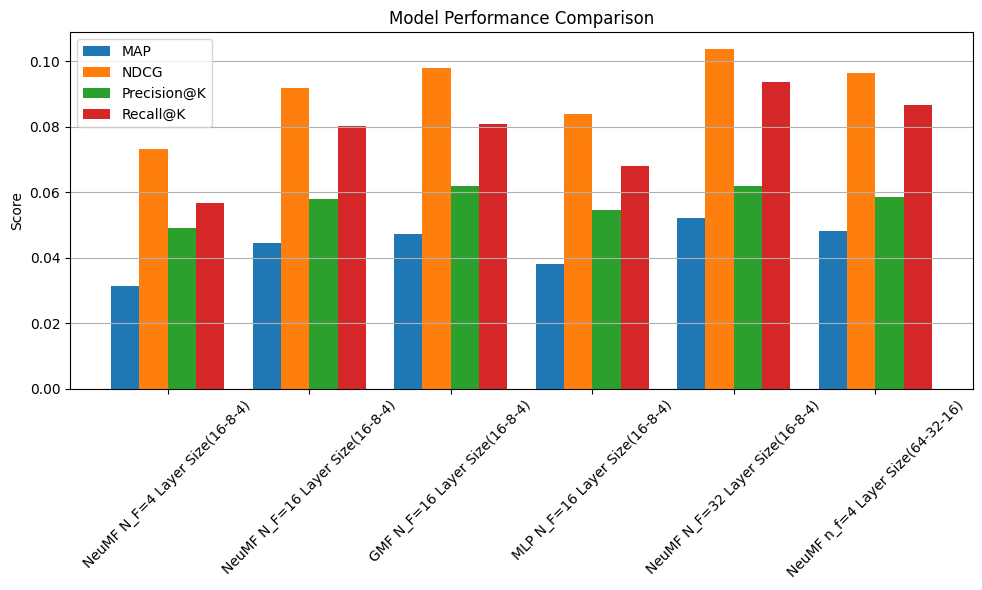

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Model performance data
compare = pd.DataFrame({
    "Model": [
        "NeuMF N_F=4 Layer Size(16-8-4)", "NeuMF N_F=16 Layer Size(16-8-4)", "GMF N_F=16 Layer Size(16-8-4)",
        "MLP N_F=16 Layer Size(16-8-4)", "NeuMF N_F=32 Layer Size(16-8-4)","NeuMF n_f=4 Layer Size(64-32-16)"
    ],
    "MAP": [0.031396, 0.044629, 0.047148, 0.038024, 0.052095,0.048182],
    "NDCG": [0.073275, 0.091884, 0.097896, 0.083776, 0.103652,0.096287],
    "Precision@K": [0.049085, 0.057776, 0.062007, 0.054574, 0.062007,0.058433],
    "Recall@K": [0.056756, 0.080322, 0.080752, 0.067928, 0.093809,0.086541]
})

# Define colors for each metric
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red

# Plot all evaluation metrics together
plt.figure(figsize=(10, 6))

bar_width = 0.2
x = range(len(compare["Model"]))

plt.bar([i - 1.5 * bar_width for i in x], compare["MAP"], width=bar_width, label="MAP", color=colors[0])
plt.bar([i - 0.5 * bar_width for i in x], compare["NDCG"], width=bar_width, label="NDCG", color=colors[1])
plt.bar([i + 0.5 * bar_width for i in x], compare["Precision@K"], width=bar_width, label="Precision@K", color=colors[2])
plt.bar([i + 1.5 * bar_width for i in x], compare["Recall@K"], width=bar_width, label="Recall@K", color=colors[3])

plt.xticks(ticks=x, labels=compare["Model"], rotation=45)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.grid(True, axis='y')

plt.show()

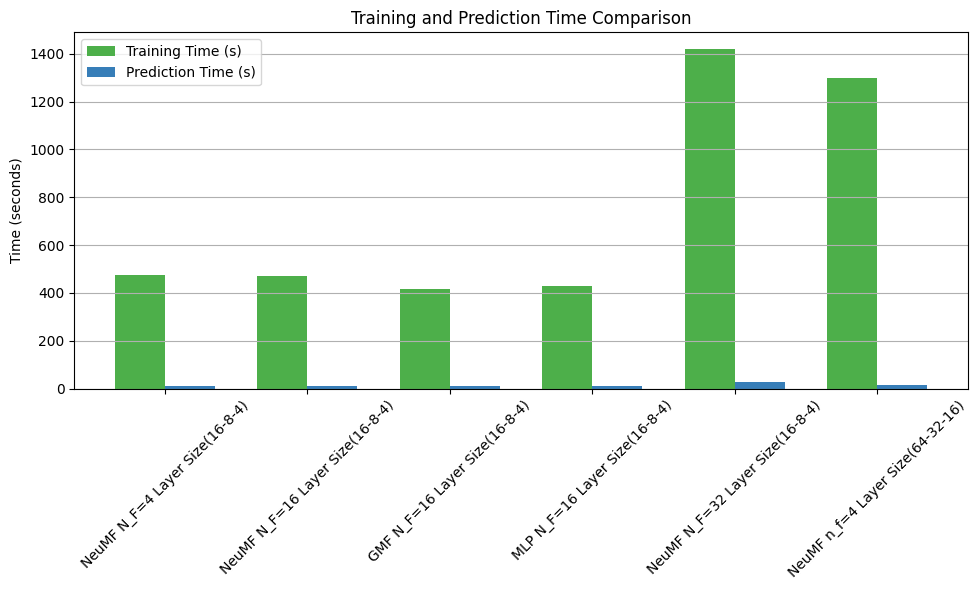

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Recreate the performance DataFrame
compare = pd.DataFrame({
    "Model": [
        "NeuMF N_F=4 Layer Size(16-8-4)", "NeuMF N_F=16 Layer Size(16-8-4)", "GMF N_F=16 Layer Size(16-8-4)",
        "MLP N_F=16 Layer Size(16-8-4)", "NeuMF N_F=32 Layer Size(16-8-4)","NeuMF n_f=4 Layer Size(64-32-16)"
    ],
    "MAP": [0.031396, 0.044629, 0.047148, 0.038024, 0.052095,0.048182],
    "NDCG": [0.073275, 0.091884, 0.097896, 0.083776, 0.103652,0.096287],
    "Precision@K": [0.049085, 0.057776, 0.062007, 0.054574, 0.062007,0.058433],
    "Recall@K": [0.056756, 0.080322, 0.080752, 0.067928, 0.093809,0.086541]
})

# Define training and prediction times
training_times = [475.03, 468.96, 416.85, 429.74, 1418.23,1296.92]
prediction_times = [12.47, 12.38, 11.94, 12.35, 29.27,14.20]

# Plotting
plt.figure(figsize=(10, 6))

bar_width = 0.35
x = range(len(compare["Model"]))

# New cleaner colors
training_color = '#4daf4a'     # Green
prediction_color = '#377eb8'   # Blue

plt.bar([i - bar_width / 2 for i in x], training_times, width=bar_width, label="Training Time (s)", color=training_color)
plt.bar([i + bar_width / 2 for i in x], prediction_times, width=bar_width, label="Prediction Time (s)", color=prediction_color)

plt.xticks(ticks=x, labels=compare["Model"], rotation=45)
plt.ylabel("Time (seconds)")
plt.title("Training and Prediction Time Comparison")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()

plt.show()
